In [11]:
###SASSIE SHIPBOARD DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

##LOCAL DIRECTORY TO TSG DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)
    
#LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
##READ IN TOPOGRAPHY/BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url) 

In [12]:
##LOAD IN THE NETCDF FILE AND LOOK AT IT'S METADATA  
file = dir_in + '/SASSIE_Fall_2022_Shipboard_TSG.nc'

#SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
ds = xr.open_dataset(file)
#print(ds)

#SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
variable_info = ds.salinity
#print(variable_info)

In [13]:
##BREAKING THE DATA UP INTO SEPERATE DATASETS FOR EACH PLAY

##PLAY START AND END DATETIMES
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play2_start = datetime(2022,9,14)
play2_end = datetime(2022,9,16)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)

play_start_dates = [play1_start,play2_start,play3_start,play4_start,play5_start,play1_start]
play_end_dates = [play1_end,play2_end,play3_end,play4_end,play5_end,play5_end]


play1_data =ds.sel(time=slice(play1_start,play1_end))
play2_data =ds.sel(time=slice(play2_start,play2_end))
play3_data =ds.sel(time=slice(play3_start,play3_end))
play4_data =ds.sel(time=slice(play4_start,play4_end))
play5_data =ds.sel(time=slice(play5_start,play5_end))
campaign_data = ds.sel(time=slice(play1_start,play5_end))

play_data_all = [play1_data,play2_data,play3_data,play4_data,play5_data,campaign_data]


In [14]:
##FOR THE FOLLOWING FUNCTIONS, INPUT 6 AS 'play' TO VIEW THE ENTIRE CAMPAIGN

In [15]:
##Map The Ship Track and contour by time 
def map_ship_track(play,bathymetry_data=True,ice_data=False):
    
    ##LOAD DATA FOR SELECTED PLAY
    time_data = np.squeeze(play_data_all[play-1]['time'])
    lat_data = np.squeeze(play_data_all[play-1]['latitude'])
    lon_data = np.squeeze(play_data_all[play-1]['longitude'])
    
    
    ##CREATE A MAP WITH LAND, CITY MARKERS, BATHYMETRY DATA, AND AMSR ICE DATA AT START AND END OF PLAY.

    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(lat_data.values)-1
    latmax = max(lat_data.values)+1
    lonmin = min(lon_data.values)-1
    lonmax = max(lon_data.values)+1
    if play == 6: 
        latmin = 70
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50',zorder=1)
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels.

    if play == 6:
        ax.set_title('Ship Track from Entire Campaign',fontsize=18) 
    else:
        ax.set_title('Ship Track from Play '+str(play),fontsize=18) 
        
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    plt.legend(loc=2)
    
    
    ##OPTIONAL MAP ADD-ONs
    
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data ==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        play_start = play_start_dates[play-1]
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_start - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_start - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        play_end = play_end_dates[play-1]
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_end - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_end - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        
        
    ##APPLY SHIP DATA TO THE MAP 
    
    track = ax.scatter(lon_data, 
                 lat_data,s=0.01, 
                 c=time_data,cmap='jet',
                   transform=cartopy.crs.PlateCarree())
    cbar = fig.colorbar(track, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    if play == 3:
        number_of_ticks = 3
    else:
        number_of_ticks = 5
    cbar_tick_array=(np.linspace(min(time_data.values).astype('int64'),max(time_data.values).astype('int64'),number_of_ticks))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+'/shiptrack'):
        os.makedirs(fig_dir+'/shiptrack')
    if play==6:
        print('Saving Output Image:  '+fig_dir+'/shiptrack/'+'SASSIE_SHIPTRACK_entire_campaign.png')
        plt.savefig(fig_dir+'/shiptrack/'+'SASSIE_SHIPTRACK_TSG_entire_campaign.png',dpi='figure',format='png')
    else:
        print('Saving Output Image:  '+fig_dir+'/shiptrack/'+'SASSIE_SHIPTRACK_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+'/shiptrack/'+'SASSIE_SHIPTRACK_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_entire_campaign.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_play_1.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_play_2.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_play_3.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_play_4.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/shiptrack/SASSIE_SHIPTRACK_play_5.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


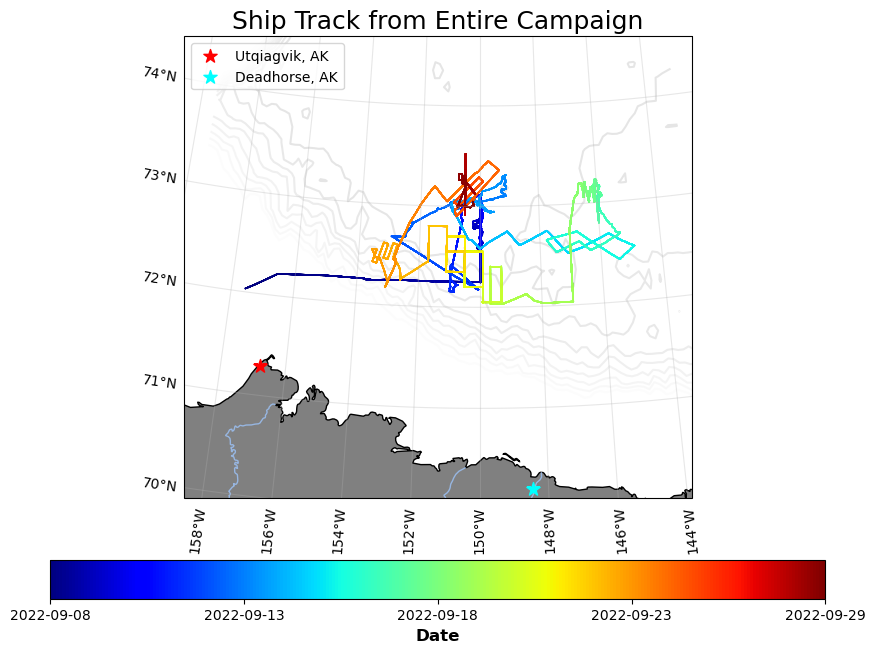

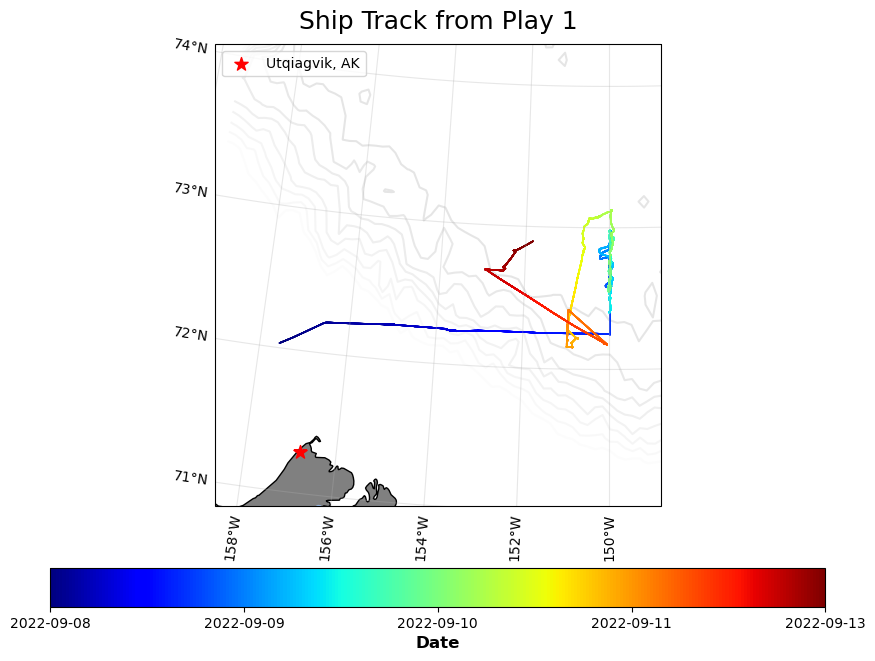

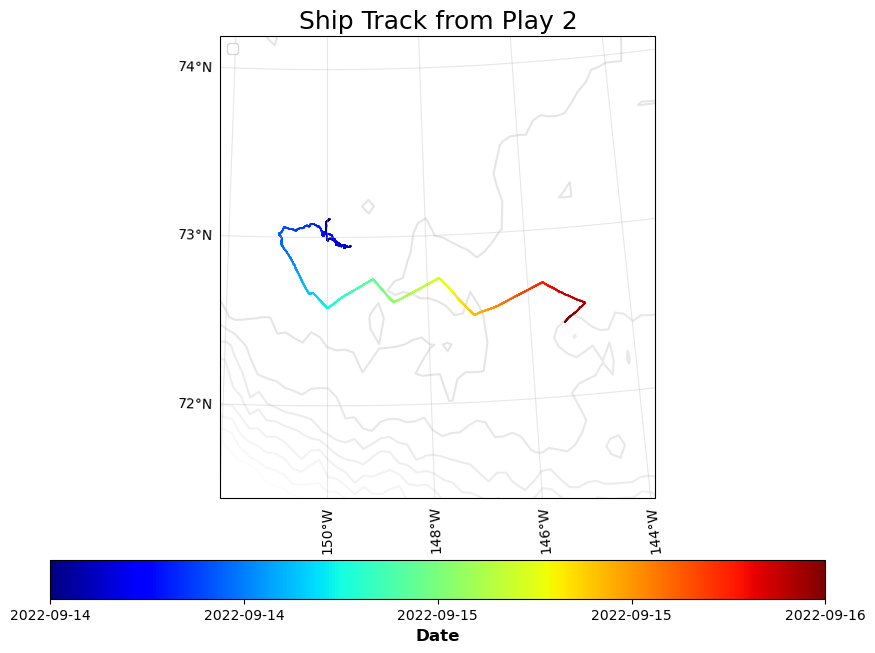

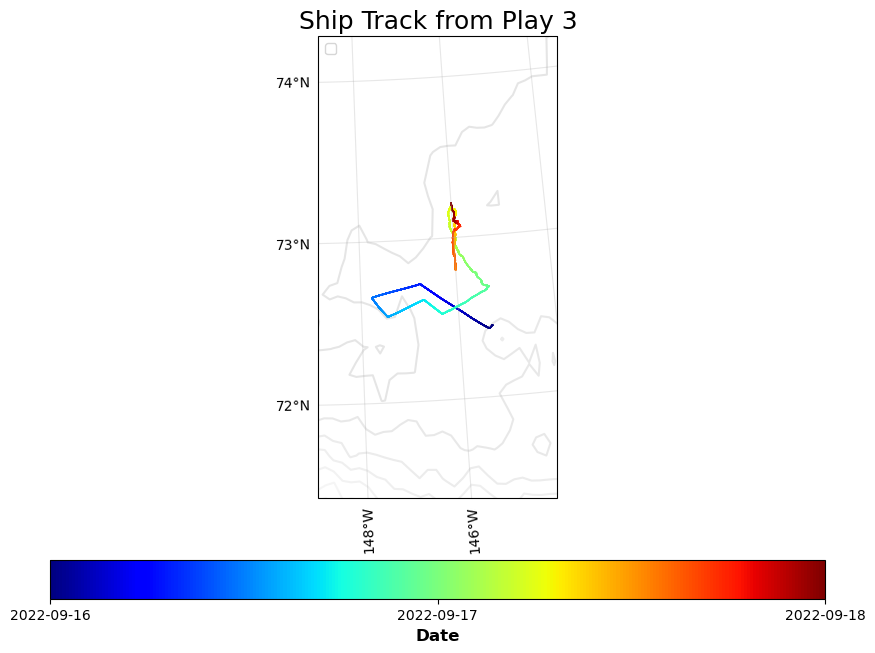

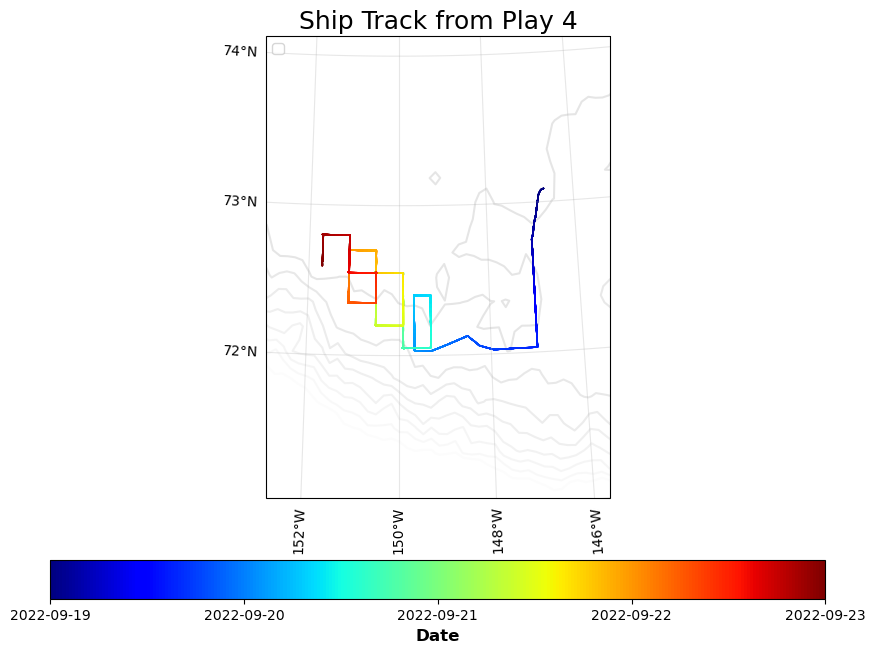

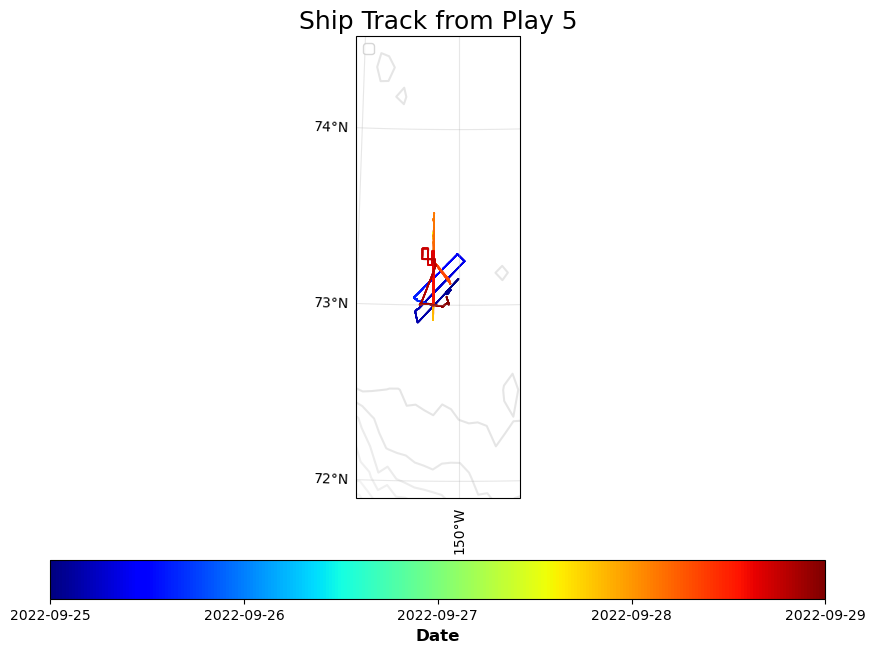

In [16]:
map_ship_track(6)
map_ship_track(1)
map_ship_track(2)
map_ship_track(3)
map_ship_track(4)
map_ship_track(5)

In [7]:
def define_variable_attributes(var): 
    if var == 'salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var == 'temperature':
        colormap = 'plasma'
        var_label = 'Temperature ($^{\circ}$C)'
    return colormap,var_label

In [8]:
## PLOT TEMP AND SALINITY DATA PLAY BY PLAY## (Version 2 with ice before and after)
def map_shipboard_data(play,var,var_min,var_max,bathymetry_data=True,ice_data=False):
    
    
    #LOAD DATA FOR SELECTED PLAY
    np_var = np.squeeze(play_data_all[play-1][var])
    np_lat = np.squeeze(play_data_all[play-1]['latitude'])
    np_lon = np.squeeze(play_data_all[play-1]['longitude'])
    
    play_start = play_start_dates[play-1]
    play_end = play_end_dates[play-1]
    
    
    ##CREATE A MAP WITH LAND, CITY MARKERS, BATHYMETRY DATA(optional), AND AMSR ICE DATA AT START AND END OF PLAY(optional).
    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(np_lat.values)-1
    latmax = max(np_lat.values)+1
    lonmin = min(np_lon.values)-1
    lonmax = max(np_lon.values)+1
    
    colormap,var_label = define_variable_attributes(var)
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels.
    
    if play == 6:
        ax.set_title('Shipboard '+ var_label+' Reading from Entire Campaign',fontsize=18) 
    else:
        ax.set_title('Shipboard '+var_label+' Reading from Play '+str(play),fontsize=18) 
        
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK')
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK')
    plt.legend(loc=2)
    
    ##ADD OPTIONAL BATHYMETRY AND/OR ICE DATA
    
    if bathymetry_data==True: 
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[:]
        lons = etopodata.etopo2_x.values[:]
        lats = etopodata.etopo2_y.values[:]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)
        
        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data ==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        play_start = play_start_dates[play-1]
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_start - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_start - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        play_end = play_end_dates[play-1]
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_end - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_end - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

    ##APPLY SHIPBOARD DATA
    track = ax.scatter(np_lon, 
                 np_lat,s=0.01, 
                 c=np_var,cmap=colormap,
                   transform=cartopy.crs.PlateCarree(),
                   vmin = var_min,
                   vmax = var_max)
                        
    matplotlib.pyplot.colorbar(track, ax=ax, orientation="horizontal", pad=0.1).set_label(label=var_label,size='large',weight='bold')
    
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+'/'+var):
        os.makedirs(fig_dir+'/'+var)
    if play == 6:
        print('Saving Output Image:  '+fig_dir+'/'+var+'/'+'SASSIE_SHIPBOARD_TSG_entire_campaign.png')
        plt.savefig(fig_dir+'/'+var+'/'+'SASSIE_SHIPBOARD_TSG_entire_campaign.png',dpi='figure',format='png')
    else: 
        print('Saving Output Image:  '+fig_dir+'/'+var+'/'+'SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+'/'+var+'/'+'SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_play_1.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_play_2.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_play_3.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_play_4.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_play_5.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/salinity/SASSIE_SHIPBOARD_TSG_entire_campaign.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_play_1.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_play_2.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_play_3.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_play_4.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_play_5.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/temperature/SASSIE_SHIPBOARD_TSG_entire_campaign.png


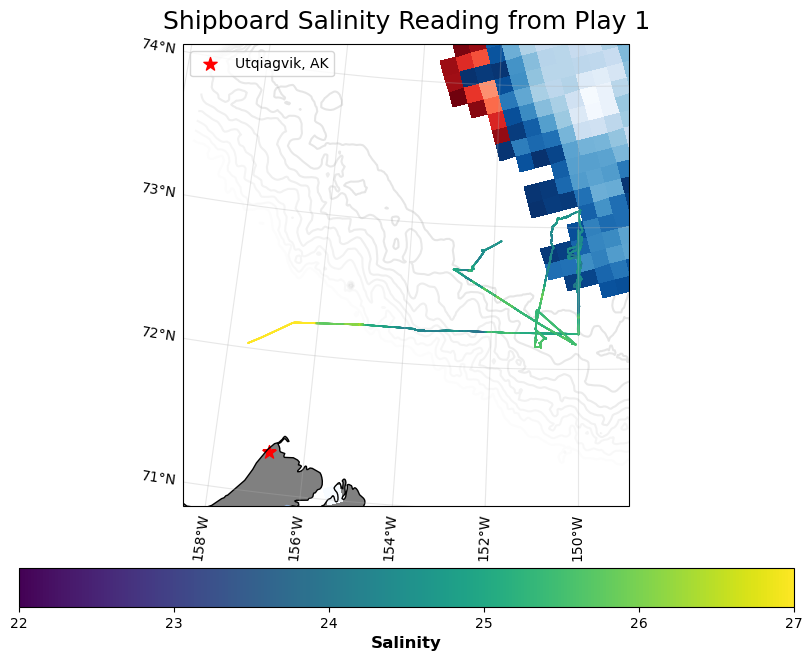

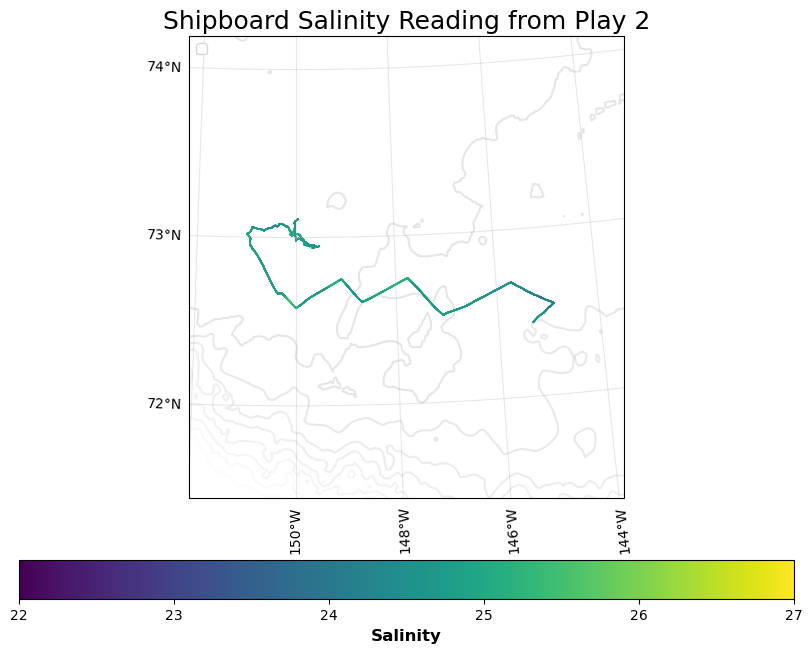

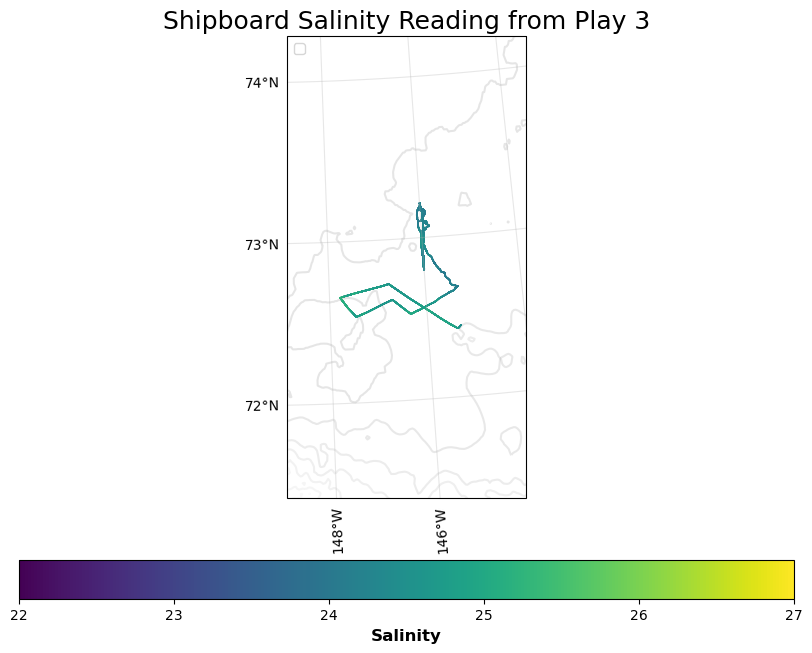

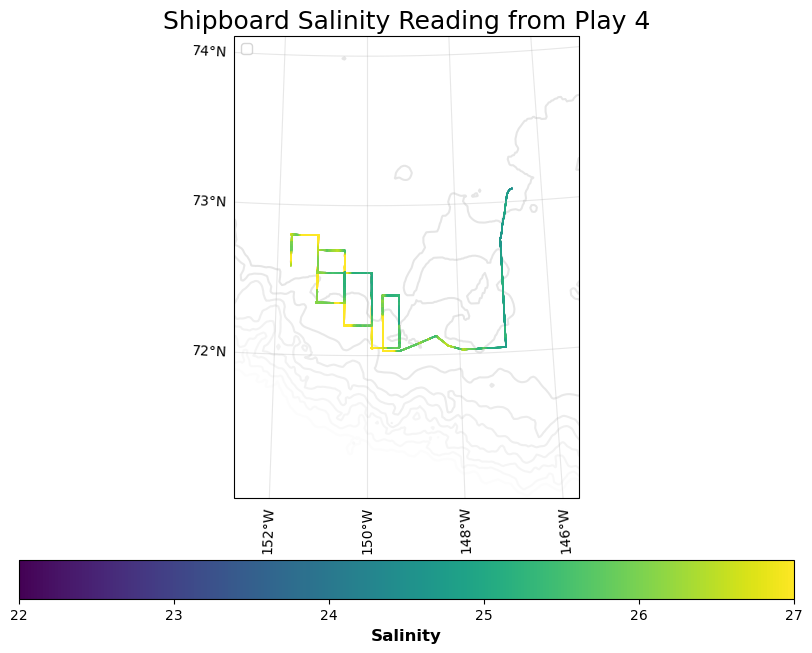

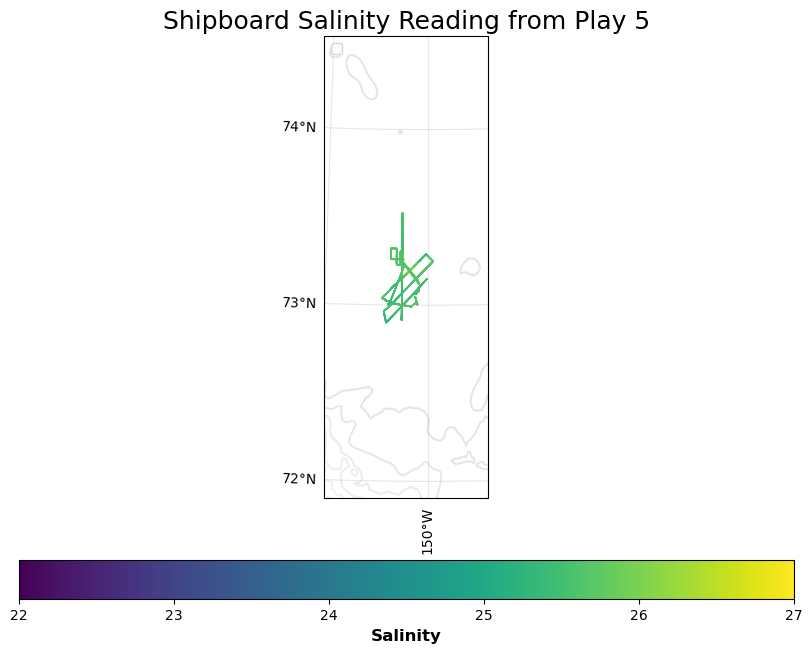

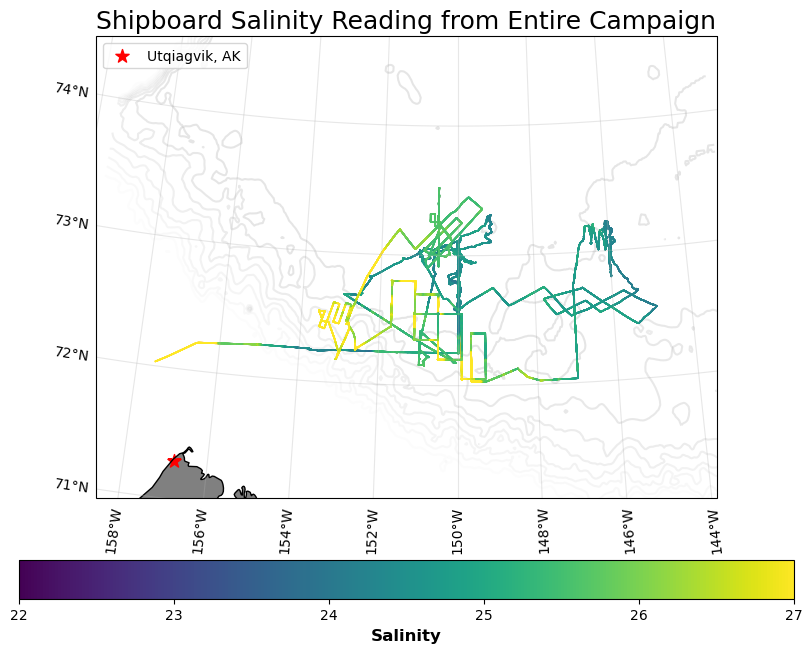

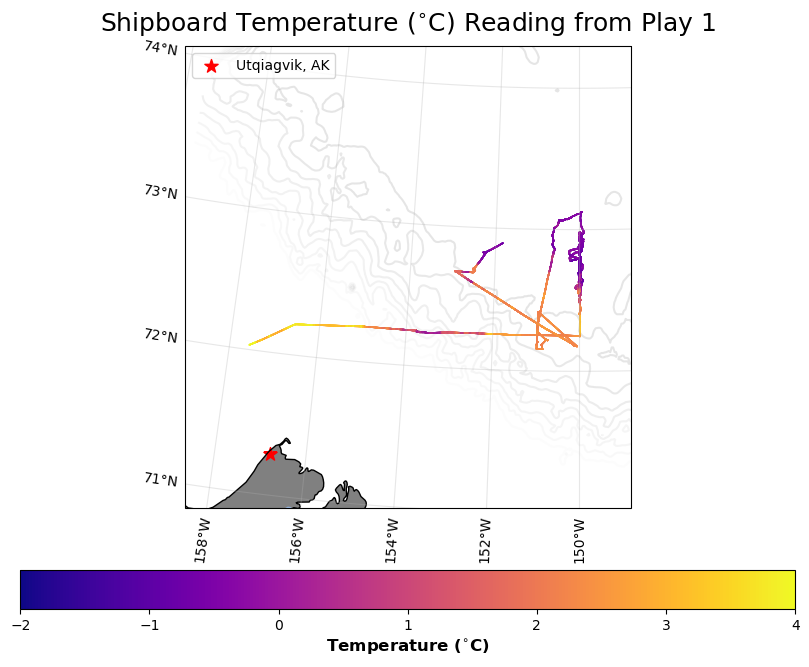

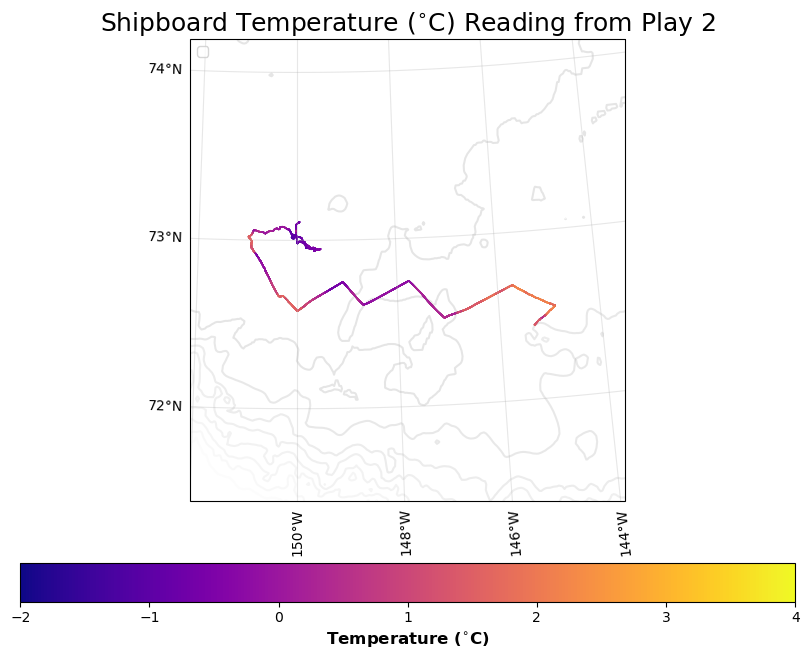

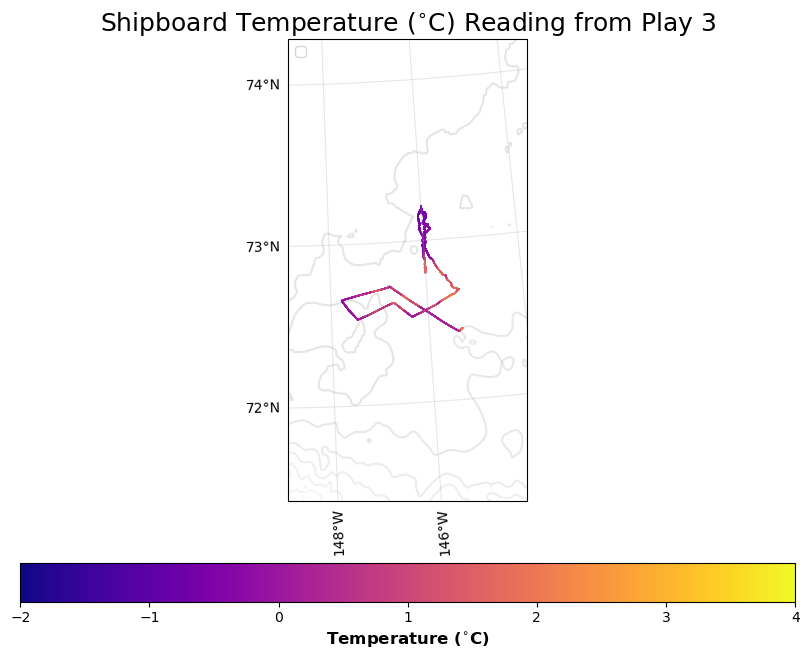

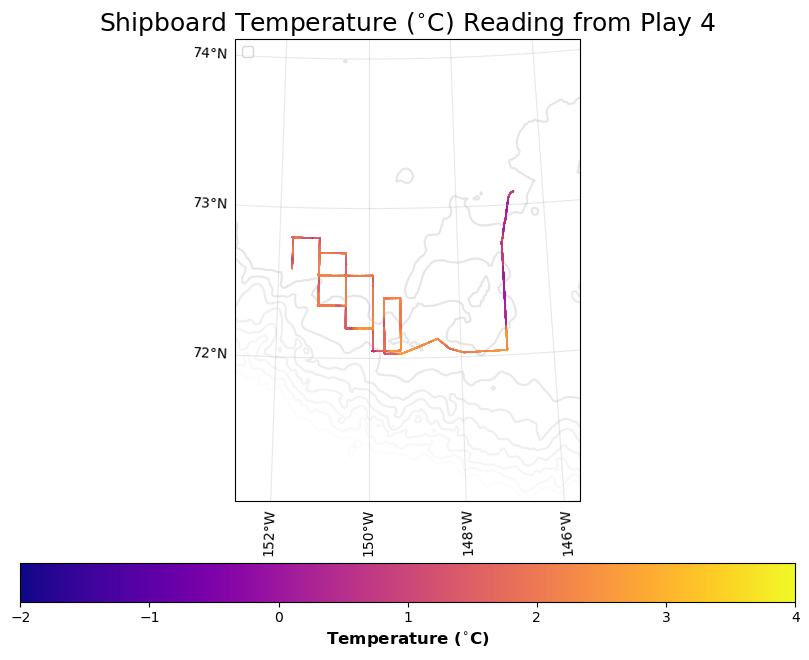

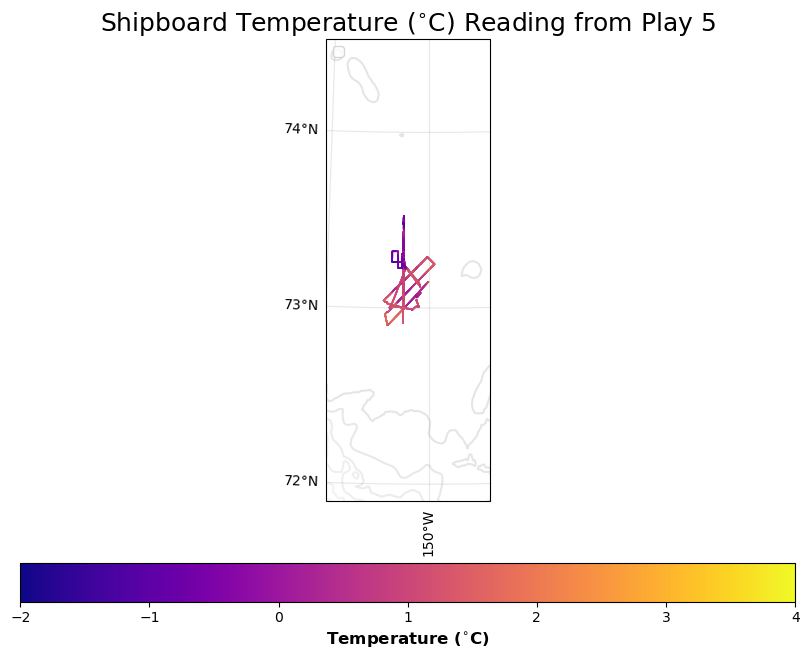

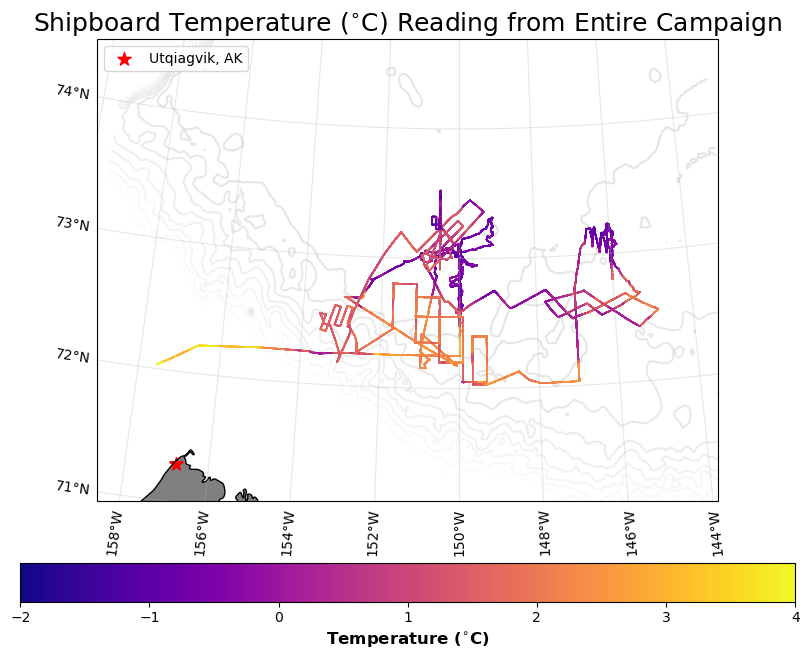

In [10]:
salinity_min = 22
salinity_max = 27


map_shipboard_data(1,'salinity',salinity_min,salinity_max)
map_shipboard_data(2,'salinity',salinity_min,salinity_max)
map_shipboard_data(3,'salinity',salinity_min,salinity_max)
map_shipboard_data(4,'salinity',salinity_min,salinity_max)
map_shipboard_data(5,'salinity',salinity_min,salinity_max)
map_shipboard_data(6,'salinity',salinity_min,salinity_max)


temp_min = -2
temp_max = 4

map_shipboard_data(1,'temperature',temp_min,temp_max)
map_shipboard_data(2,'temperature',temp_min,temp_max)
map_shipboard_data(3,'temperature',temp_min,temp_max)
map_shipboard_data(4,'temperature',temp_min,temp_max)
map_shipboard_data(5,'temperature',temp_min,temp_max)
map_shipboard_data(6,'temperature',temp_min,temp_max)


In [23]:
def plot_shipboard_timeseries(play): 
    
    #SECLECT AND LOAD PLAY DATA
    play_start = play_start_dates[play-1]
    play_end = play_end_dates[play-1]
    
    time_data = np.squeeze(play_data_all[play-1]['time'])
    temp_data = np.squeeze(play_data_all[play-1]['temperature'])
    sal_data = np.squeeze(play_data_all[play-1]['salinity'])
    
    
    #MAKE A TWO PANNELED TIME SERIES PLOT
    fig,axs = plt.subplots(2,sharex=True)
    
    axs[0].plot(time_data,temp_data,linewidth=0.4,color='k')
    axs[0].set(ylabel='Temperature ($^{\circ}$C)')
    axs[1].plot(time_data,sal_data,linewidth=0.4,color='k')
    axs[1].set(ylabel='Salinity',xlabel='Date')
    
    plt.xticks(pd.date_range(start=time_data.values[0],end=time_data.values[-1],periods=3))
    
    
    if play <=5:
        fig.suptitle('Play '+str(play)+' Temperature and Salinity Data from Shipboard TSG')
    if play == 6: 
        fig.suptitle('Temperature and Salinity Data from Shipboard TSG (Entire Campaign)')
        
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'/timeseries'):
        os.makedirs(fig_dir+'/timeseries')
    if play==6: 
        print('Saving Output Image:  '+fig_dir+'/timeseries/SASSIE_SHIPBOARD_TSG_entire_campaign.png')
        plt.savefig(fig_dir+'/timeseries/SASSIE_SHIPBOARD_TSG_entire_campaign.png',dpi='figure',format='png')
    else:
        print('Saving Output Image:  '+fig_dir+'/timeseries/SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+'/timeseries/SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SASSIE_SHIPBOARD_TSG_entire_campaign.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SASSIE_SHIPBOARD_TSG_play_1.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SASSIE_SHIPBOARD_TSG_play_2.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SASSIE_SHIPBOARD_TSG_play_3.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SASSIE_SHIPBOARD_TSG_play_4.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/TSG/timeseries/SAS

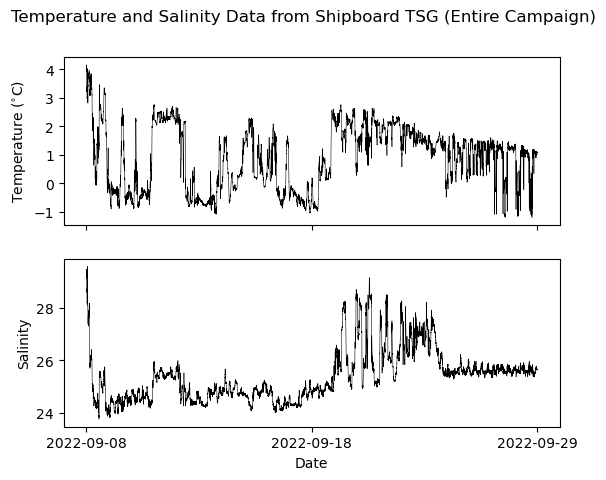

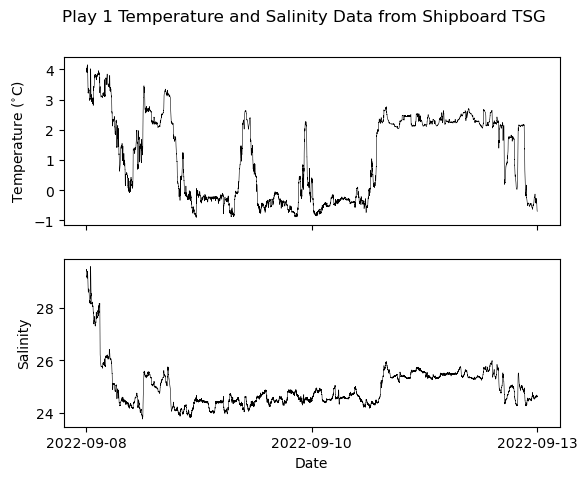

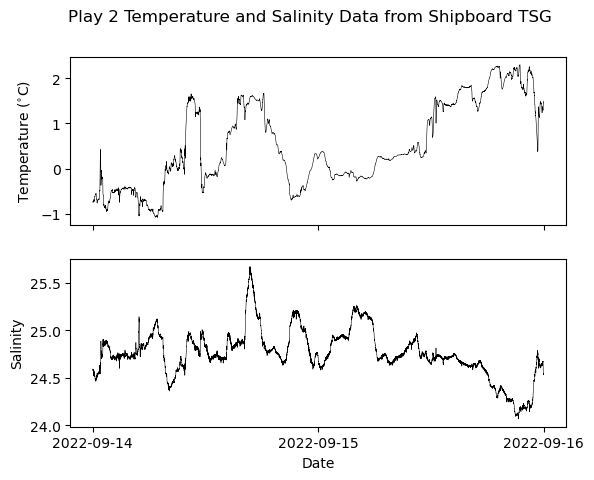

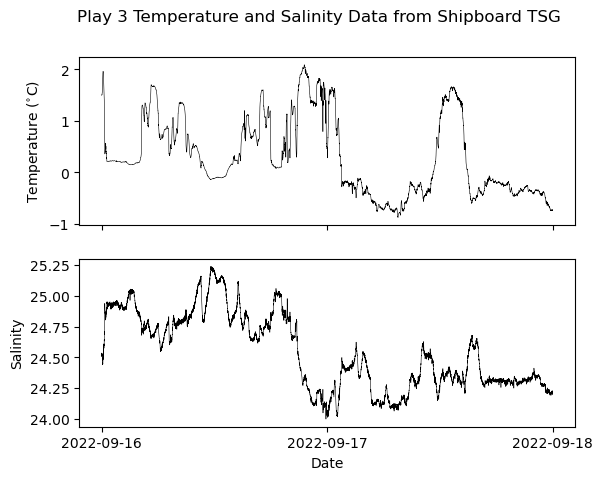

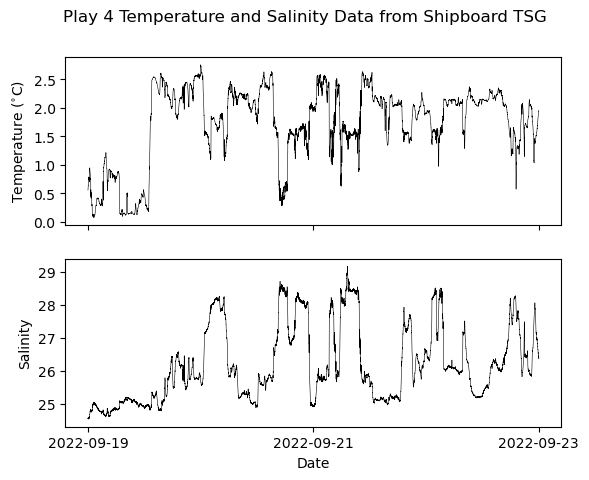

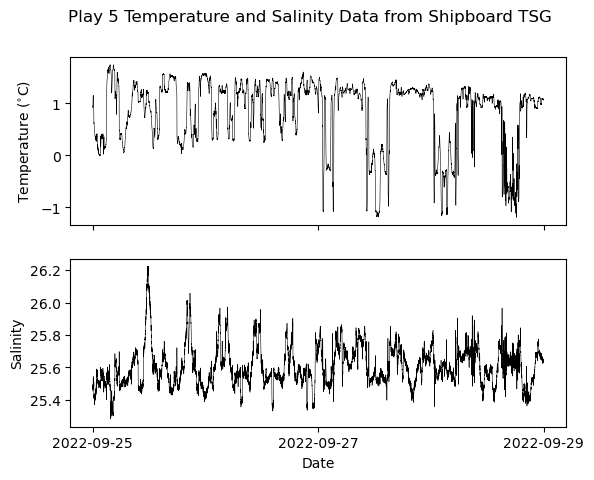

In [24]:
plot_shipboard_timeseries(6)
plot_shipboard_timeseries(1)
plot_shipboard_timeseries(2)
plot_shipboard_timeseries(3)
plot_shipboard_timeseries(4)
plot_shipboard_timeseries(5)